### Importer les bibliothèques

In [29]:
%pip install tensorflow
%pip install --upgrade tensorflow matplotlib ipython

import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Charger le jeu de données

Lien : https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/

Télécharger facades.tar.gz

In [ ]:
%tar -xvf facades.tar.gz

dataset_name = "facades"

sample_image = tf.io.read_file(dataset_name+"/train/1.jpg")
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)


(256, 512, 3)


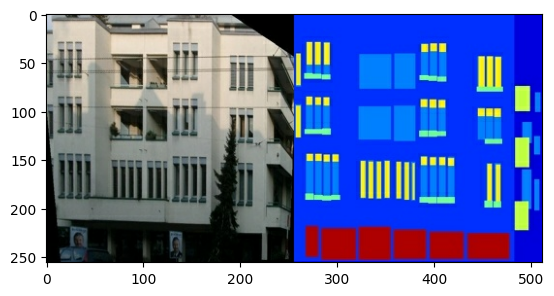

In [5]:
plt.figure()
plt.imshow(sample_image)

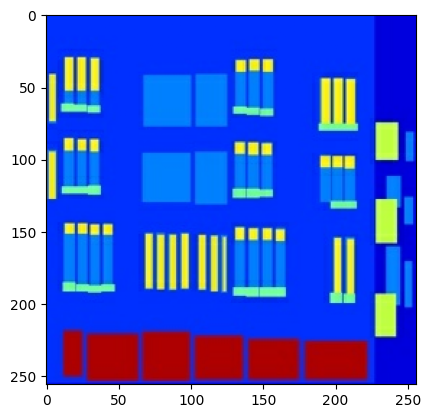

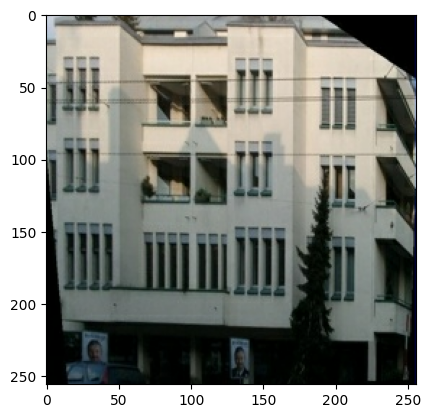

In [13]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

inp, re = load(dataset_name+"/train/1.jpg")

plt.figure()
plt.imshow(inp / 255)
plt.figure()
plt.imshow(re / 255)


In [14]:
BUFFER_SIZE = 400 # Number of images in the training set
BATCH_SIZE = 1 # Better results with batch size one for the U-Net in pix2pix

IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def resize(input_image,real_image,height,width):
    input_image = tf.image.resize(input_image, [height,width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image,real_image

In [ ]:
def random_crop(input_image,real_image):
    stacked_image = tf.stack([input_image,real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,3]
    )

    return cropped_image[0],cropped_image[1]

In [17]:
def normalize(input_image,real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image,real_image

In [ ]:
# Conversion en graphe de calcul
@tf.function()
def random_jitter(input_image,real_image):
    input_image,real_image = resize(input_image,real_image,286,286)
    input_image,real_image = random_crop(input_image,real_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image,real_image

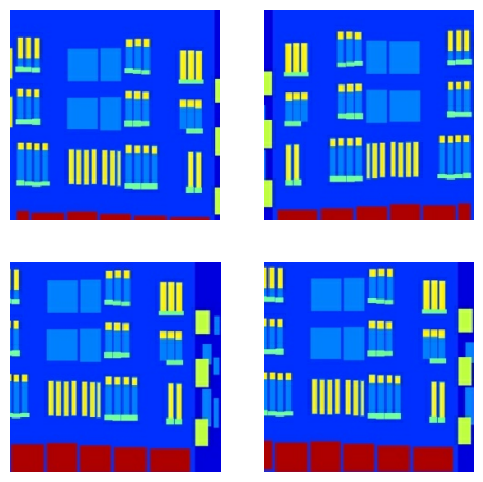

In [21]:
plt.figure(figsize=(6,6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp,re)
    plt.subplot(2,2,i+1)
    plt.imshow(rj_inp / 255.0)
    plt.axis("off")
plt.show()

In [22]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [25]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

### Construire un pipeline d'entrée avec tf.data

In [23]:
train_dataset = tf.data.Dataset.list_files(dataset_name+"/train/*.jpg")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [26]:
try:
    test_dataset = tf.data.Dataset.list_files(dataset_name+"/test/*.jpg")
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(dataset_name+"/val/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Construire le générateur (U-Net modifié)

In [ ]:
from keras import Sequential, layers

OUTPUT_CHANNELS = 3

# Sous-échantillonneur (étape down du U-Net)
def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    """
    Les poids du noyau de la couche conv2d suivent une loi normale N(0,0.02)
    L'initialisation aléatoire permet d'éviter que les neurones aient les mêmes valeurs au départ
    Cela permet de limiter les problèmes de symétrie dans l'entrainement
    """

    model = Sequential(
        layers.Conv2D(filters,kernel_size,strides=2,padding="same",
                      kernel_initializer=initializer,use_bias=False)
    )
    # stride=2 : divise par 2 la taille de l'image de sortie par rapport à l'image d'entrée
    # padding=same : l'image de sortie aura la même taille (ou presque) que l'image d'entrée
    # Ce résultat s'obtient en ajoutant des 0 autour de l'image si nécessaire

    if apply_batchnorm:
        model.add(layers.BatchNormalization())
    
    model.add(layers.LeakyReLU())

    return model